# **Janatahack: Cross-sell Prediction**

[https://datahack.analyticsvidhya.com/contest/janatahack-cross-sell-prediction/#ProblemStatement](http://)

Your client is an Insurance company that has provided Health Insurance to its customers now they need your help in building a model to predict whether the policyholders (customers) from past year will also be interested in Vehicle Insurance provided by the company.

An insurance policy is an arrangement by which a company undertakes to provide a guarantee of compensation for specified loss, damage, illness, or death in return for the payment of a specified premium. A premium is a sum of money that the customer needs to pay regularly to an insurance company for this guarantee.

For example, you may pay a premium of Rs. 5000 each year for a health insurance cover of Rs. 200,000/- so that if, God forbid, you fall ill and need to be hospitalised in that year, the insurance provider company will bear the cost of hospitalisation etc. for upto Rs. 200,000. Now if you are wondering how can company bear such high hospitalisation cost when it charges a premium of only Rs. 5000/-, that is where the concept of probabilities comes in picture. For example, like you, there may be 100 customers who would be paying a premium of Rs. 5000 every year, but only a few of them (say 2-3) would get hospitalised that year and not everyone. This way everyone shares the risk of everyone else.

Just like medical insurance, there is vehicle insurance where every year customer needs to pay a premium of certain amount to insurance provider company so that in case of unfortunate accident by the vehicle, the insurance provider company will provide a compensation (called ‘sum assured’) to the customer.

Building a model to predict whether a customer would be interested in Vehicle Insurance is extremely helpful for the company because it can then accordingly plan its communication strategy to reach out to those customers and optimise its business model and revenue. 

Now, in order to predict, whether the customer would be interested in Vehicle insurance, you have information about demographics (gender, age, region code type), Vehicles (Vehicle Age, Damage), Policy (Premium, sourcing channel) etc.

# Import the Libraries

In [57]:
import pandas as pd
import numpy as np
import matplotlib as pyplot
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier
%matplotlib inline

In [58]:
# to see all the comands result in a single kernal 
%load_ext autoreload
%autoreload 2
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [59]:
# to increase no. of rows and column visibility in outputs
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Import the dataset

In [60]:
train = pd.read_csv(r'../input/janatahack-crosssell-prediction/train.csv')
test = pd.read_csv(r'../input/janatahack-crosssell-prediction/test.csv')
sample_submmission = pd.read_csv(r'../input/janatahack-crosssell-prediction/sample_submission.csv')
train.shape
test.shape
sample_submmission.shape

(381109, 12)

(127037, 11)

(127037, 2)

In [61]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127037 entries, 0 to 127036
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    127037 non-null  int64  
 1   Gender                127037 non-null  object 
 2   Age                   127037 non-null  int64  
 3   Driving_License       127037 non-null  int64  
 4   Region_Code           127037 non-null  float64
 5   Previously_Insured    127037 non-null  int64  
 6   Vehicle_Age           127037 non-null  object 
 7   Vehicle_Damage        127037 non-null  object 
 8   Annual_Premium        127037 non-null  float64
 9   Policy_Sales_Channel  127037 non-null  float64
 10  Vintage               127037 non-null  int64  
dtypes: float64(3), int64(5), object(3)
memory usage: 10.7+ MB


# Basic Visualization

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa1fa3332d0>,
      dtype=object)

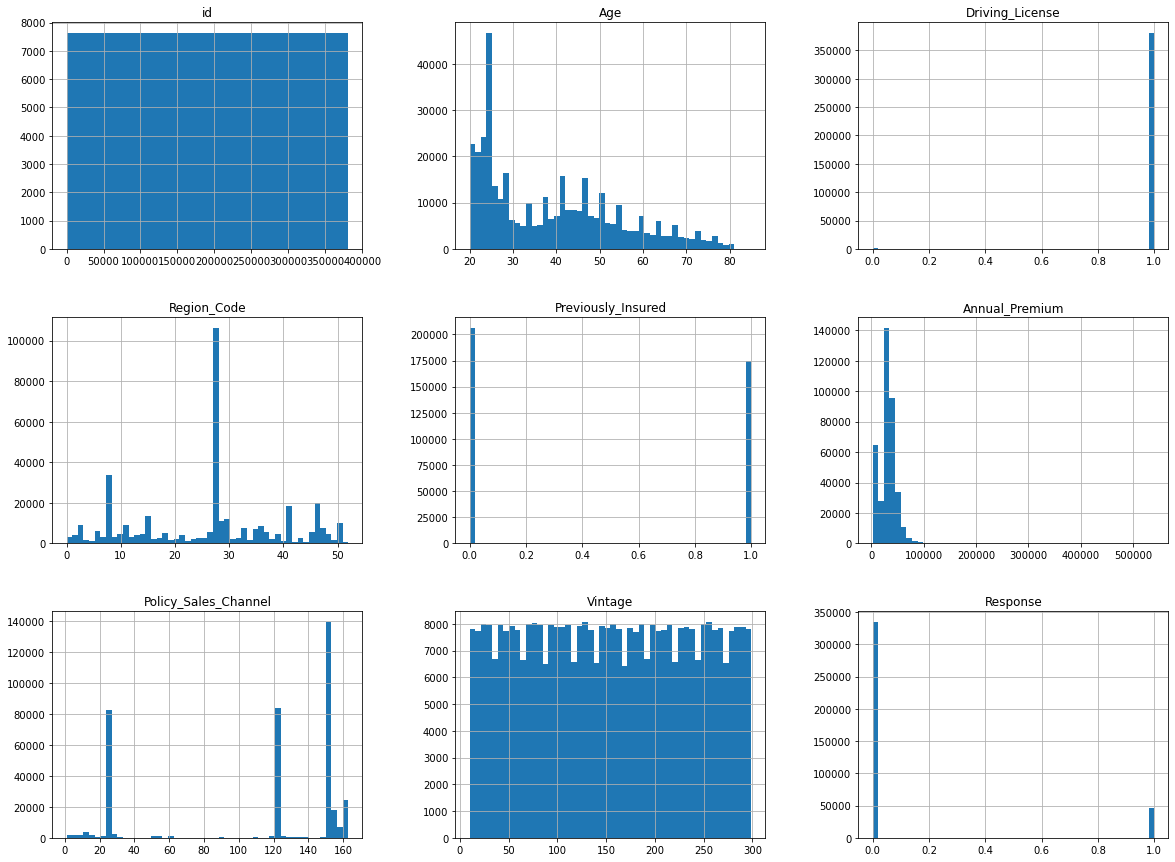

In [62]:
%matplotlib inline
import matplotlib.pyplot as plt
train.hist(bins=50, figsize=(20,15))
plt.show()

In [63]:
train.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


# Check for Missing Data

In [64]:
train.isna().sum().sum()
test.isna().sum().sum()

0

0

# Identifying Numerical Features

In [65]:
numeric_data = train.select_dtypes(include=np.number) # select_dtypes selects data with numeric features
numeric_col = numeric_data.columns 

print("Numeric Features:")
print(numeric_data.head())
print("===="*20)

Numeric Features:
   id  Age  Driving_License  Region_Code  Previously_Insured  Annual_Premium  Policy_Sales_Channel  Vintage  Response
0   1   44                1         28.0                   0         40454.0                  26.0      217         1
1   2   76                1          3.0                   0         33536.0                  26.0      183         0
2   3   47                1         28.0                   0         38294.0                  26.0       27         1
3   4   21                1         11.0                   1         28619.0                 152.0      203         0
4   5   29                1         41.0                   1         27496.0                 152.0       39         0


# Identifying Categorical Features

In [66]:
categorical_data = train.select_dtypes(exclude=np.number) # we will exclude data with numeric features
categorical_col = categorical_data.columns                                                                              # we will store the categorical features in a variable

print("Categorical Features:")
print(categorical_data.head())
print("===="*20)

Categorical Features:
   Gender Vehicle_Age Vehicle_Damage
0    Male   > 2 Years            Yes
1    Male    1-2 Year             No
2    Male   > 2 Years            Yes
3    Male    < 1 Year             No
4  Female    < 1 Year             No


In [67]:
train['Response'].value_counts()/len(train)
train['Gender'].value_counts()
train['Vehicle_Age'].value_counts()
train['Vehicle_Damage'].value_counts()

0    0.877437
1    0.122563
Name: Response, dtype: float64

Male      206089
Female    175020
Name: Gender, dtype: int64

1-2 Year     200316
< 1 Year     164786
> 2 Years     16007
Name: Vehicle_Age, dtype: int64

Yes    192413
No     188696
Name: Vehicle_Damage, dtype: int64

# Label Encoding categorical features

In [68]:
le = LabelEncoder()
train['Vehicle_Age'] = le.fit_transform(train['Vehicle_Age'])
train['Gender'] = le.fit_transform(train['Gender'])
train['Vehicle_Damage'] = le.fit_transform(train['Vehicle_Damage'])
test['Gender'] = le.fit_transform(test['Gender'])
test['Vehicle_Age'] = le.fit_transform(test['Vehicle_Age'])
test['Vehicle_Damage'] = le.fit_transform(test['Vehicle_Damage'])

In [69]:
train.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,1,44,1,28.0,0,2,1,40454.0,26.0,217,1
1,2,1,76,1,3.0,0,0,0,33536.0,26.0,183,0
2,3,1,47,1,28.0,0,2,1,38294.0,26.0,27,1
3,4,1,21,1,11.0,1,1,0,28619.0,152.0,203,0
4,5,0,29,1,41.0,1,1,0,27496.0,152.0,39,0


In [70]:
train.columns

Index(['id', 'Gender', 'Age', 'Driving_License', 'Region_Code', 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage', 'Response'], dtype='object')

In [71]:
col_1=['Gender', 'Age','Driving_License', 'Region_Code', 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage']

In [72]:
# categorical column 
cat_col=['Gender','Driving_License', 'Region_Code', 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage','Policy_Sales_Channel']

# Since cat_feature in catboost cannot be float changing data type

In [73]:
train['Region_Code']=train['Region_Code'].astype(int)
test['Region_Code']=test['Region_Code'].astype(int)
train['Policy_Sales_Channel']=train['Policy_Sales_Channel'].astype(int)
test['Policy_Sales_Channel']=test['Policy_Sales_Channel'].astype(int)


In [96]:
X = train[col_1]
y = train['Response']
X_test = test[col_1]
y_valid_pred = 0
y_test_pred = 0

# Applying k-fold validation

In [90]:
K = 4
kf = KFold(n_splits = K, random_state=150307, shuffle = True)

# Implementing CatBoost Classifier

In [91]:
OPTIMIZE_ROUNDS = False
# Run CV
model = CatBoostClassifier()

for i, (train_i, test_i) in enumerate(kf.split(train)):
    
    # Create data for this fold
    y_train, y_eval = y.iloc[train_i], y.iloc[test_i]
    X_train, X_eval = X.iloc[train_i,:], X.iloc[test_i,:]
    print( "\nFold ", i)
    
    # Run model for this fold
    if OPTIMIZE_ROUNDS:
        fit_model = model.fit( X_train, y_train, 
                               eval_set=[X_eval, y_eval],
                               use_best_model=True
                             )
        print( "  N trees = ", model.tree_count_ )
    else:
        fit_model = model.fit( X_train, y_train,cat_features=cat_col,eval_set=(X_eval, y_eval),early_stopping_rounds=40,verbose=200 )
        
    # Generate validation predictions for this fold
    pred = fit_model.predict_proba(X_eval)[:,1]
    print( "  ROCAUC = ", roc_auc_score(y_eval, pred) )
    y_valid_pred.iloc[test_i] = pred
    
    # Accumulate test set predictions
    y_test_pred += fit_model.predict_proba(test[col_1])[:, 1]
    
y_test_pred /= K  # Average test set predictions

print( "\nROCAUC for full training set:" )
roc_auc_score(y, y_valid_pred)


Fold  0
Learning rate set to 0.128106
0:	learn: 0.4924345	test: 0.4920732	best: 0.4920732 (0)	total: 248ms	remaining: 4m 7s
200:	learn: 0.2619659	test: 0.2626564	best: 0.2626347 (192)	total: 39s	remaining: 2m 35s
Stopped by overfitting detector  (40 iterations wait)

bestTest = 0.2625411864
bestIteration = 313

Shrink model to first 314 iterations.
  ROCAUC =  0.8581792530259006

Fold  1
Learning rate set to 0.128106
0:	learn: 0.4928630	test: 0.4928956	best: 0.4928956 (0)	total: 217ms	remaining: 3m 37s
Stopped by overfitting detector  (40 iterations wait)

bestTest = 0.2633288856
bestIteration = 158

Shrink model to first 159 iterations.
  ROCAUC =  0.8600355329630887

Fold  2
Learning rate set to 0.128106
0:	learn: 0.4911814	test: 0.4912735	best: 0.4912735 (0)	total: 214ms	remaining: 3m 33s
200:	learn: 0.2605834	test: 0.2661503	best: 0.2661015 (178)	total: 38s	remaining: 2m 31s
Stopped by overfitting detector  (40 iterations wait)

bestTest = 0.2661015081
bestIteration = 178

Shrink 

0.8586364654562884

# Test Data Prediction

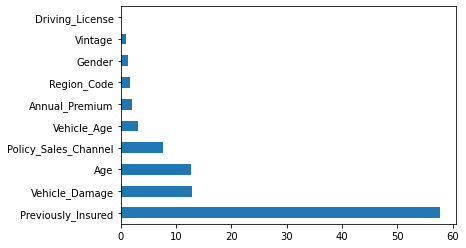

In [92]:
feat_importances = pd.Series(fit_model.feature_importances_, index=X_train.columns)
feat_importances.nlargest(15).plot(kind='barh')
#feat_importances.nsmallest(20).plot(kind='barh')
plt.show()

In [94]:
# Create submission file
submmission = pd.DataFrame()
submmission['id'] = test['id'].values
submmission['Response'] = y_test_pred
submmission.to_csv('cat_submitfinal.csv', float_format='%.6f', index=False)

In [95]:
submmission.head()

,id,Response
0,381110,0.000494
1,381111,0.391886
2,381112,0.390108
3,381113,0.007858
4,381114,0.000461


In [80]:
# 85.86 on Public leaderboard